# 1. Loading necessary packages

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

# Getting the GPU if one can be found
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 2. Loading the Cisco stock price data

Extracting the closing prices only

In [45]:
# Reading the CSV file of the stock price data
cisco_df = pd.read_csv('CSCO.csv')
cisco = cisco_df['Close'].values
cisco

array([23.01    , 23.280001, 23.34    , ..., 53.07    , 53.450001,
       53.919998])

Splitting the time series data into three parts and performing Min-Max Scaling. The scaler is fitted on the training data and get synchronised onto the validation and testing data.

In [3]:
from sklearn.preprocessing import MinMaxScaler

def split_and_scale_data(stock_array, lookback, train_ratio, val_ratio):

    # Creating all the sequences based on the lookback
    main_sequence = []
    for index in range(len(stock_array) - lookback):
        main_sequence.append(stock_array[index: index + lookback + 1])

    main_sequence = np.array(main_sequence)
    train_set_size = round(train_ratio * len(main_sequence))
    val_set_size = round(val_ratio * len(main_sequence))

    train_sequence = main_sequence[:train_set_size].reshape(train_set_size, lookback + 1)
    val_sequence = main_sequence[train_set_size:train_set_size+val_set_size].reshape(val_set_size, lookback + 1)
    test_sequence = main_sequence[train_set_size+val_set_size:].reshape(len(main_sequence) - train_set_size - val_set_size, lookback + 1)

    # Scaling at this stage to make sure the target 'y' is also scaled
    mm_scaler = MinMaxScaler(feature_range=(-1, 1))
    train_sequence = mm_scaler.fit_transform(train_sequence).reshape(train_set_size, lookback + 1, 1)
    val_sequence = mm_scaler.transform(val_sequence).reshape(val_set_size, lookback + 1, 1)
    test_sequence = mm_scaler.transform(test_sequence).reshape(len(main_sequence) - train_set_size - val_set_size, lookback + 1, 1)

    x_train = train_sequence[:, :-1]
    y_train = train_sequence[:, -1]

    x_val = val_sequence[:, :-1]
    y_val = val_sequence[:, -1]

    x_test = test_sequence[:, :-1]
    y_test = test_sequence[:, -1]

    return [x_train, y_train, x_val, y_val, x_test, y_test, mm_scaler] # Return the scaler for the inverse transformation of predictions later


lookback = 50 # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test, mm_scaler = split_and_scale_data(
    cisco.reshape(-1, 1), lookback, train_ratio = 0.8, val_ratio = 0.1)

Using data loader to put the data in a Pytorch-compatible format

In [4]:
from torch.utils.data import DataLoader, Dataset

class DatasetObject(Dataset):
    def __init__(self, X_array, target_array):
        self.X = X_array
        self.y = target_array

    def __getitem__(self, index):
        if isinstance(index, torch.Tensor):
            index = index.tolist()
        return [self.X[index, :], self.y[index]]

    def __len__(self):
        return self.X.shape[0]

In [5]:
cisco_train_ds = DatasetObject(x_train, y_train)
cisco_val_ds = DatasetObject(x_val, y_val)
cisco_test_ds = DatasetObject(x_test, y_test)

cisco_train = DataLoader(cisco_train_ds, batch_size = 64, shuffle = False)
cisco_val = DataLoader(cisco_val_ds, batch_size = 64, shuffle = False)
cisco_test = DataLoader(cisco_test_ds, batch_size = 64, shuffle = False)

# 3. Hyperparameter optimisation 

*(Exhaustive search to find the best hyperparameter setting to train each of the three RNN models)*

Defining a function to train a model on the training data and evaluate it on the validation data

In [6]:
from sklearn.metrics import mean_squared_error
from copy import deepcopy

def train_and_validate_model(model, criterion, optim, epochs, train_loader, val_loader, device, print_log: bool):
    """This function is to train a model on the training data and then validate it on validation
    data at the same time so that not only the validation scores could be obtained but a training
    log could also be produced. For each epoch, the training loss, training RMSE, validation loss,
    validation RMSE, and the lowest RMSE score reached are recorded for the training log."""

    training_log = pd.DataFrame({'epoch': [], 'training_loss' : [], 'training_RMSE': [], 'validation_loss': [],
                                 'validation_RMSE': [], 'best_validation_rmse_reached': []})
    best_val_rmse_reached = 99999999999999999

    for epoch in range(epochs):
        # Training the model on the training set
        total_train_loss = 0
        y_train_true, y_train_pred = [], []

        model.train() # Set the model to training mode
        for train_X, train_y in train_loader:
            # get the training inputs and true values in device
            train_X, train_y = train_X.float().to(device), train_y.float().to(device)

            optim.zero_grad()
            y_pred = model(train_X)

            y_train_true.extend(train_y.cpu().numpy())
            y_train_pred.extend(y_pred.cpu().detach().numpy())

            current_batch_train_loss = criterion(y_pred, train_y)
            total_train_loss += current_batch_train_loss.item() # Incrementing the total training loss of the current epoch
            current_batch_train_loss.backward()
            optim.step()

        train_loss = total_train_loss / len(train_loader) # Total accumulated loss divided by the number of batches
        train_rmse = mean_squared_error(y_true = y_train_true, y_pred = y_train_pred, squared = False)

        # Evaluating on the validation set
        total_val_loss = 0
        y_val_true, y_val_pred = [], []

        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for val_X, val_y in val_loader:
                # get the validation inputs and true values in device
                val_X, val_y = val_X.float().to(device), val_y.float().to(device)
                y_pred = model(val_X)

                current_batch_val_loss = criterion(y_pred, val_y)
                total_val_loss += current_batch_val_loss.item() # Incrementing the total validation loss of the current epoch
                y_val_true.extend(val_y.cpu().numpy())
                y_val_pred.extend(y_pred.cpu().detach().numpy())

        val_loss = total_val_loss / len(val_loader) # Total accumulated loss divided by the number of batches
        val_rmse = mean_squared_error(y_true = y_val_true, y_pred = y_val_pred, squared = False)

        # Save the model weights that returned the best (lowest) validation RMSE
        if val_rmse < best_val_rmse_reached:
            best_val_rmse_reached = val_rmse
            torch.save(f = "best_model.pt", obj = deepcopy(model.state_dict()))

        # Display the training log if needed
        if print_log == True:
            print('Epoch:', epoch+1, '| Training Loss:', round(train_loss, 3),
                  '| Training RMSE:', round(train_rmse, 3),
                  '| Validation Loss:', round(val_loss, 3),
                  '| Validation RMSE:', round(val_rmse, 3),
                  '| Best Validation RMSE Reached:', round(best_val_rmse_reached, 3),
                  sep = " ")

        # Updating the training log dataframe to return at the end
        training_log.loc[len(training_log)] = [epoch + 1, train_loss, train_rmse, val_loss, val_rmse, best_val_rmse_reached]

    return training_log

### a. For the Vanilla RNN model

In [ ]:
class MyVanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyVanillaRNN, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = x.device).requires_grad_()
        out, (h0) = self.rnn(x, h0.detach())
        out = self.linear(out[:, -1, :])
        return out

In [ ]:
hyperparams_space = {'epochs': [10, 20, 30],
                     'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                     'optimiser': ['SGD', 'Adam', 'RMSprop'],
                     'hidden_dim': [16, 32, 64],
                     'num_layers': [3, 4, 5]}

rnn_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'hidden_dim': [],
     'num_layers': [], 'best_validation_rmse_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            for hidden_dim in hyperparams_space['hidden_dim']:
                for num_layers in hyperparams_space['num_layers']:
                    torch.manual_seed(99) # For reproducibility purpose
                    my_rnn = MyVanillaRNN(input_dim = 1, hidden_dim = hidden_dim,
                                          output_dim = 1, num_layers = num_layers)
                    my_rnn.to(device)
                    my_criterion = nn.MSELoss()

                    if optimiser == 'SGD':
                        my_optimiser = torch.optim.SGD(params = my_rnn.parameters(), lr = lr)
                    if optimiser == 'Adam':
                        my_optimiser = torch.optim.Adam(params = my_rnn.parameters(), lr = lr)
                    if optimiser == 'RMSprop':
                        my_optimiser = torch.optim.RMSprop(params = my_rnn.parameters(), lr = lr)

                    training_log_df = train_and_validate_model(
                        model = my_rnn, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                        train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = False)

                    best_val_rmse_reached = training_log_df['best_validation_rmse_reached'].values[-1]

                    rnn_hyperparams_tune_result.loc[len(rnn_hyperparams_tune_result)] = [
                        epochs, lr, optimiser, hidden_dim, num_layers, best_val_rmse_reached]

In [ ]:
rnn_hyperparams_tune_result.sort_values('best_validation_rmse_reached')

,max_epochs,learning_rate,optimiser,hidden_dim,num_layers,best_validation_rmse_reached
342,30,0.0010,RMSprop,16,3,0.079128
369,30,0.0050,RMSprop,16,3,0.082235
315,30,0.0005,RMSprop,16,3,0.083458
207,20,0.0010,RMSprop,16,3,0.083721
306,30,0.0005,Adam,16,3,0.087804
...,...,...,...,...,...,...
141,20,0.0001,SGD,64,3,0.736534
6,10,0.0001,SGD,64,3,0.738972
277,30,0.0001,SGD,64,4,0.752746
142,20,0.0001,SGD,64,4,0.754904


### b.For the LSTM model

In [7]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
hyperparams_space = {'epochs': [10, 20, 30],
                     'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                     'optimiser': ['SGD', 'Adam', 'RMSprop'],
                     'hidden_dim': [16, 32, 64],
                     'num_layers': [3, 4, 5]}

lstm_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'hidden_dim': [],
     'num_layers': [], 'best_validation_rmse_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            for hidden_dim in hyperparams_space['hidden_dim']:
                for num_layers in hyperparams_space['num_layers']:
                    torch.manual_seed(99) # For reproducibility purpose
                    my_lstm = MyLSTM(input_dim = 1, hidden_dim = hidden_dim,
                                      output_dim = 1, num_layers = num_layers)
                    my_lstm.to(device)
                    my_criterion = nn.MSELoss()

                    if optimiser == 'SGD':
                        my_optimiser = torch.optim.SGD(params = my_lstm.parameters(), lr = lr)
                    if optimiser == 'Adam':
                        my_optimiser = torch.optim.Adam(params = my_lstm.parameters(), lr = lr)
                    if optimiser == 'RMSprop':
                        my_optimiser = torch.optim.RMSprop(params = my_lstm.parameters(), lr = lr)

                    training_log_df = train_and_validate_model(
                        model = my_lstm, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                        train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = False)

                    best_val_rmse_reached = training_log_df['best_validation_rmse_reached'].values[-1]

                    lstm_hyperparams_tune_result.loc[len(lstm_hyperparams_tune_result)] = [
                        epochs, lr, optimiser, hidden_dim, num_layers, best_val_rmse_reached]

In [ ]:
lstm_hyperparams_tune_result.sort_values('best_validation_rmse_reached')

,max_epochs,learning_rate,optimiser,hidden_dim,num_layers,best_validation_rmse_reached
396,30,0.0100,RMSprop,16,3,0.074943
397,30,0.0100,RMSprop,16,4,0.087906
369,30,0.0050,RMSprop,16,3,0.091173
372,30,0.0050,RMSprop,32,3,0.097149
336,30,0.0010,Adam,32,3,0.105641
...,...,...,...,...,...,...
162,20,0.0005,SGD,16,3,0.764941
27,10,0.0005,SGD,16,3,0.769462
270,30,0.0001,SGD,16,3,0.772676
135,20,0.0001,SGD,16,3,0.773728


### c. For the GRU model

In [12]:
class MyGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = x.device).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
hyperparams_space = {'epochs': [10, 20, 30],
                     'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                     'optimiser': ['SGD', 'Adam', 'RMSprop'],
                     'hidden_dim': [16, 32, 64],
                     'num_layers': [3, 4, 5]}

gru_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'hidden_dim': [],
     'num_layers': [], 'best_validation_rmse_reached': []})

for epochs in hyperparams_space['epochs']:
    for lr in hyperparams_space['lr']:
        for optimiser in hyperparams_space['optimiser']:
            for hidden_dim in hyperparams_space['hidden_dim']:
                for num_layers in hyperparams_space['num_layers']:
                    torch.manual_seed(99) # For reproducibility purpose
                    my_gru = MyGRU(input_dim = 1, hidden_dim = hidden_dim,
                                   output_dim = 1, num_layers = num_layers)
                    my_gru.to(device)
                    my_criterion = nn.MSELoss()

                    if optimiser == 'SGD':
                        my_optimiser = torch.optim.SGD(params = my_gru.parameters(), lr = lr)
                    if optimiser == 'Adam':
                        my_optimiser = torch.optim.Adam(params = my_gru.parameters(), lr = lr)
                    if optimiser == 'RMSprop':
                        my_optimiser = torch.optim.RMSprop(params = my_gru.parameters(), lr = lr)

                    training_log_df = train_and_validate_model(
                        model = my_gru, optim = my_optimiser, epochs = epochs, criterion = my_criterion,
                        train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = False)

                    best_val_rmse_reached = training_log_df['best_validation_rmse_reached'].values[-1]

                    gru_hyperparams_tune_result.loc[len(gru_hyperparams_tune_result)] = [
                        epochs, lr, optimiser, hidden_dim, num_layers, best_val_rmse_reached]

In [ ]:
gru_hyperparams_tune_result.sort_values('best_validation_rmse_reached')

,max_epochs,learning_rate,optimiser,hidden_dim,num_layers,best_validation_rmse_reached
96,10,0.0050,Adam,64,3,0.061194
366,30,0.0050,Adam,64,3,0.061194
231,20,0.0050,Adam,64,3,0.061194
393,30,0.0100,Adam,64,3,0.077137
321,30,0.0005,RMSprop,64,3,0.078945
...,...,...,...,...,...,...
3,10,0.0001,SGD,32,3,0.749913
27,10,0.0005,SGD,16,3,0.756573
270,30,0.0001,SGD,16,3,0.765012
135,20,0.0001,SGD,16,3,0.767422


# 4. Train each model again with their best hyperparameter setting

Defining to show the learning curves of each model

In [10]:
# A function to smoothen the learning curves, similar to Tensorboard
def tensorboard_smooth(values: list, weight: float = 0.6):
    last = values[0]  # First value in the plot (first timestep)
    smoothed = []
    for point in values:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

### a. The best Vanilla model is built with the following hyperparameters:

- max_epochs: 30
- learning_rate: 0.001
- optimiser: RMSprop
- hidden_dim: 16
- num_layer: 3

In [ ]:
torch.manual_seed(99) # For reproducibility purpose
my_rnn = MyVanillaRNN(input_dim = 1, hidden_dim = 16,
                      output_dim = 1, num_layers = 3)
my_rnn.to(device)
my_optimiser = torch.optim.RMSprop(params = my_rnn.parameters(), lr = 0.001)
my_criterion = nn.MSELoss()

my_rnn_training_log_df = train_and_validate_model(
    model = my_rnn, optim = my_optimiser, epochs = 30, criterion = my_criterion,
    train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = True)

Epoch: 1 | Training Loss: 0.143 | Training RMSE: 0.378 | Validation Loss: 0.06 | Validation RMSE: 0.243 | Best Validation RMSE Reached: 0.243
Epoch: 2 | Training Loss: 0.04 | Training RMSE: 0.202 | Validation Loss: 0.016 | Validation RMSE: 0.127 | Best Validation RMSE Reached: 0.127
Epoch: 3 | Training Loss: 0.01 | Training RMSE: 0.101 | Validation Loss: 0.013 | Validation RMSE: 0.114 | Best Validation RMSE Reached: 0.114
Epoch: 4 | Training Loss: 0.008 | Training RMSE: 0.089 | Validation Loss: 0.012 | Validation RMSE: 0.108 | Best Validation RMSE Reached: 0.108
Epoch: 5 | Training Loss: 0.007 | Training RMSE: 0.082 | Validation Loss: 0.011 | Validation RMSE: 0.105 | Best Validation RMSE Reached: 0.105
Epoch: 6 | Training Loss: 0.006 | Training RMSE: 0.078 | Validation Loss: 0.011 | Validation RMSE: 0.103 | Best Validation RMSE Reached: 0.103
Epoch: 7 | Training Loss: 0.006 | Training RMSE: 0.074 | Validation Loss: 0.01 | Validation RMSE: 0.101 | Best Validation RMSE Reached: 0.101
Epo

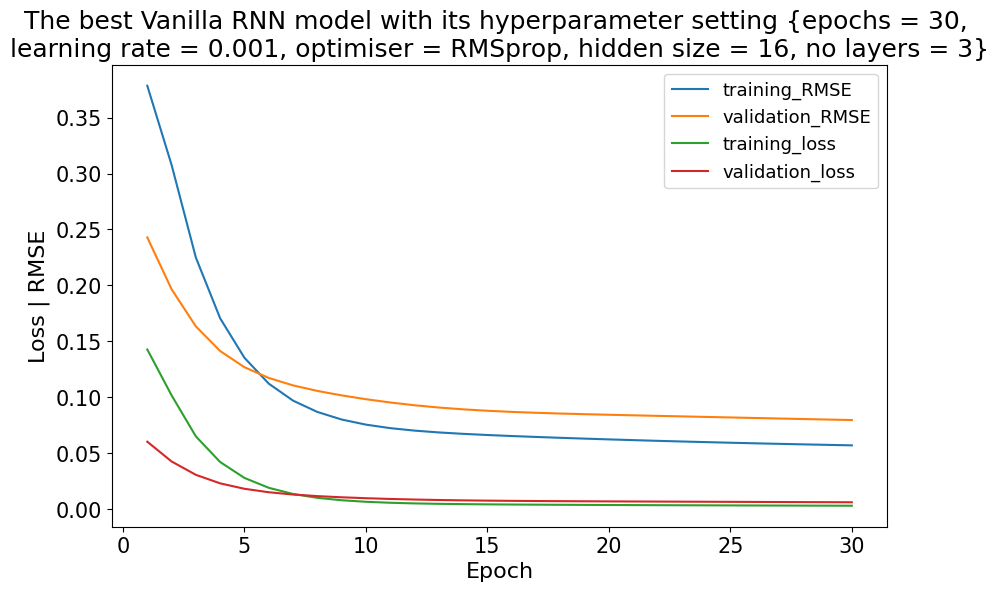

In [ ]:
import matplotlib.pyplot as plt

# Plotting the learning curves of the chosen model (DenseNet-121)
plt.figure(figsize = (10, 6))
plt.plot(my_rnn_training_log_df['epoch'], tensorboard_smooth(my_rnn_training_log_df['training_RMSE'], 0.6), label = "training_RMSE")
plt.plot(my_rnn_training_log_df['epoch'], tensorboard_smooth(my_rnn_training_log_df['validation_RMSE'], 0.6), label = "validation_RMSE")
plt.plot(my_rnn_training_log_df['epoch'], tensorboard_smooth(my_rnn_training_log_df['training_loss'], 0.6), label = "training_loss")
plt.plot(my_rnn_training_log_df['epoch'], tensorboard_smooth(my_rnn_training_log_df['validation_loss'], 0.6), label = "validation_loss")
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss | RMSE', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(prop={'size': 13})
plt.title('The best Vanilla RNN model with its hyperparameter setting {epochs = 30, \nlearning rate = 0.001, optimiser = RMSprop, hidden size = 16, no layers = 3}', fontsize = 18)
plt.show()

### b. The best LSTM model is built with the following hyperparameters:

- max_epochs: 30
- learning_rate: 0.01
- optimiser: RMSprop
- hidden_dim: 16
- num_layer: 3

In [8]:
torch.manual_seed(99) # For reproducibility purpose
my_lstm = MyLSTM(input_dim = 1, hidden_dim = 16,
                 output_dim = 1, num_layers = 3)
my_lstm.to(device)
my_optimiser = torch.optim.RMSprop(params = my_lstm.parameters(), lr = 0.01)
my_criterion = nn.MSELoss()

my_lstm_training_log_df = train_and_validate_model(
    model = my_lstm, optim = my_optimiser, epochs = 30, criterion = my_criterion,
    train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = True)

Epoch: 1 | Training Loss: 0.11 | Training RMSE: 0.332 | Validation Loss: 0.186 | Validation RMSE: 0.422 | Best Validation RMSE Reached: 0.422
Epoch: 2 | Training Loss: 0.232 | Training RMSE: 0.483 | Validation Loss: 0.149 | Validation RMSE: 0.379 | Best Validation RMSE Reached: 0.379
Epoch: 3 | Training Loss: 0.122 | Training RMSE: 0.35 | Validation Loss: 0.128 | Validation RMSE: 0.353 | Best Validation RMSE Reached: 0.353
Epoch: 4 | Training Loss: 0.059 | Training RMSE: 0.243 | Validation Loss: 0.082 | Validation RMSE: 0.283 | Best Validation RMSE Reached: 0.283
Epoch: 5 | Training Loss: 0.034 | Training RMSE: 0.185 | Validation Loss: 0.049 | Validation RMSE: 0.219 | Best Validation RMSE Reached: 0.219
Epoch: 6 | Training Loss: 0.02 | Training RMSE: 0.142 | Validation Loss: 0.026 | Validation RMSE: 0.162 | Best Validation RMSE Reached: 0.162
Epoch: 7 | Training Loss: 0.013 | Training RMSE: 0.112 | Validation Loss: 0.021 | Validation RMSE: 0.144 | Best Validation RMSE Reached: 0.144
Ep

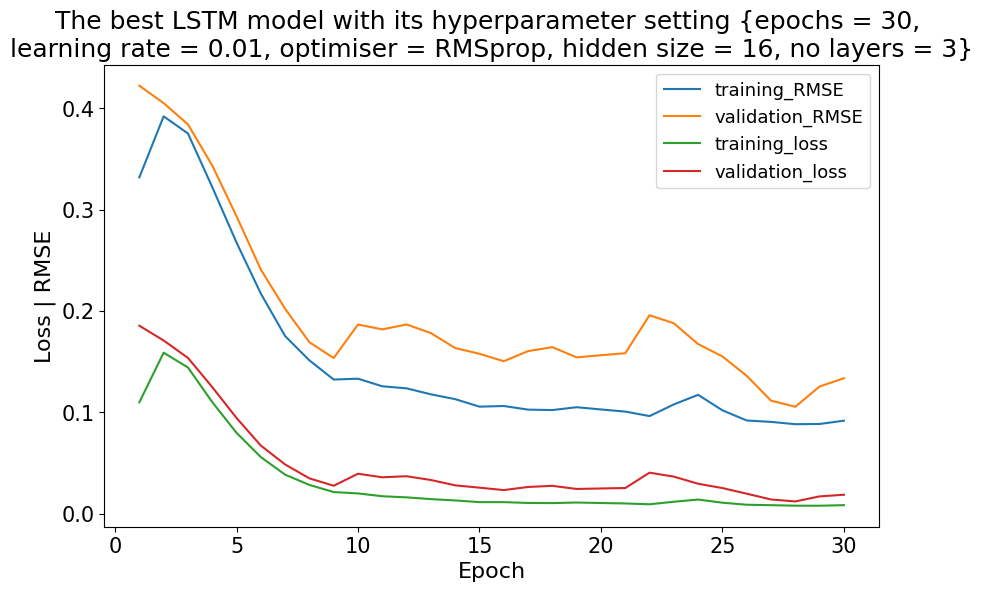

In [11]:
import matplotlib.pyplot as plt

# Plotting the learning curves of the chosen model (DenseNet-121)
plt.figure(figsize = (10, 6))
plt.plot(my_lstm_training_log_df['epoch'], tensorboard_smooth(my_lstm_training_log_df['training_RMSE'], 0.6), label = "training_RMSE")
plt.plot(my_lstm_training_log_df['epoch'], tensorboard_smooth(my_lstm_training_log_df['validation_RMSE'], 0.6), label = "validation_RMSE")
plt.plot(my_lstm_training_log_df['epoch'], tensorboard_smooth(my_lstm_training_log_df['training_loss'], 0.6), label = "training_loss")
plt.plot(my_lstm_training_log_df['epoch'], tensorboard_smooth(my_lstm_training_log_df['validation_loss'], 0.6), label = "validation_loss")
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss | RMSE', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(prop={'size': 13})
plt.title('The best LSTM model with its hyperparameter setting {epochs = 30, \nlearning rate = 0.01, optimiser = RMSprop, hidden size = 16, no layers = 3}', fontsize = 18)
plt.show()

### c. The best GRU model is built with the following hyperparameters:

- max_epochs: 30
- learning_rate: 0.005
- optimiser: Adam
- hidden_dim: 64
- num_layer: 3

In [13]:
torch.manual_seed(99) # For reproducibility purpose
my_gru = MyGRU(input_dim = 1, hidden_dim = 64,
               output_dim = 1, num_layers = 3)
my_gru.to(device)
my_optimiser = torch.optim.Adam(params = my_gru.parameters(), lr = 0.005)
my_criterion = nn.MSELoss()

# Train to 30 epochs to show that the model starts overfitting from epoch 8
my_gru_training_log_df = train_and_validate_model(
    model = my_gru, optim = my_optimiser, epochs = 10, criterion = my_criterion,
    train_loader = cisco_train, val_loader = cisco_val, device = device, print_log = True)

Epoch: 1 | Training Loss: 0.201 | Training RMSE: 0.447 | Validation Loss: 0.18 | Validation RMSE: 0.431 | Best Validation RMSE Reached: 0.431
Epoch: 2 | Training Loss: 0.148 | Training RMSE: 0.386 | Validation Loss: 0.022 | Validation RMSE: 0.146 | Best Validation RMSE Reached: 0.146
Epoch: 3 | Training Loss: 0.026 | Training RMSE: 0.162 | Validation Loss: 0.009 | Validation RMSE: 0.094 | Best Validation RMSE Reached: 0.094
Epoch: 4 | Training Loss: 0.013 | Training RMSE: 0.113 | Validation Loss: 0.011 | Validation RMSE: 0.105 | Best Validation RMSE Reached: 0.094
Epoch: 5 | Training Loss: 0.023 | Training RMSE: 0.151 | Validation Loss: 0.008 | Validation RMSE: 0.089 | Best Validation RMSE Reached: 0.089
Epoch: 6 | Training Loss: 0.027 | Training RMSE: 0.164 | Validation Loss: 0.005 | Validation RMSE: 0.07 | Best Validation RMSE Reached: 0.07
Epoch: 7 | Training Loss: 0.029 | Training RMSE: 0.169 | Validation Loss: 0.008 | Validation RMSE: 0.092 | Best Validation RMSE Reached: 0.07
Epo

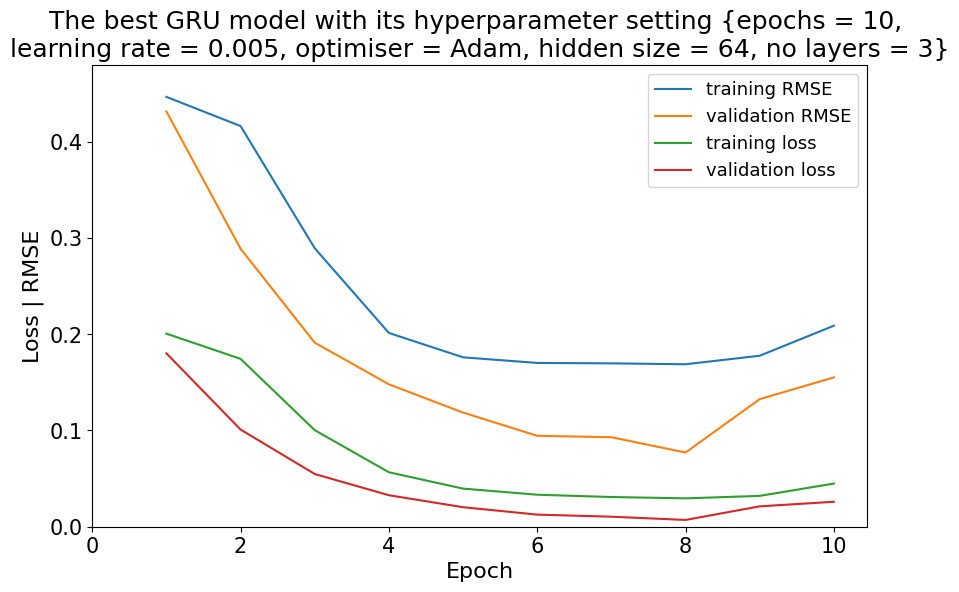

In [18]:
import matplotlib.pyplot as plt

# Plotting the learning curves of the chosen model (DenseNet-121)
plt.figure(figsize = (10, 6))
plt.plot(my_gru_training_log_df['epoch'], tensorboard_smooth(my_gru_training_log_df['training_RMSE'], 0.5), label = "training RMSE")
plt.plot(my_gru_training_log_df['epoch'], tensorboard_smooth(my_gru_training_log_df['validation_RMSE'], 0.5), label = "validation RMSE")
plt.plot(my_gru_training_log_df['epoch'], tensorboard_smooth(my_gru_training_log_df['training_loss'], 0.5), label = "training loss")
plt.plot(my_gru_training_log_df['epoch'], tensorboard_smooth(my_gru_training_log_df['validation_loss'], 0.5), label = "validation loss")
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss | RMSE', fontsize = 16)
plt.xticks(np.arange(0, 11, 2), fontsize = 15)
plt.yticks(np.arange(0, 0.6, 0.1), fontsize = 15)
plt.ylim(0, 0.48)
plt.legend(prop={'size': 13})
plt.title('The best GRU model with its hyperparameter setting {epochs = 10, \nlearning rate = 0.005, optimiser = Adam, hidden size = 64, no layers = 3}', fontsize = 18)
plt.show()

# 5. Final evaluation on the best model

Based on the validation RMSE scores, the GRU model appear to be most effective among the three, so it will be proceeded to the final evaluation stage on the testing data.

In [ ]:
# Loading the model file
my_gru = MyGRU(input_dim = 1, hidden_dim = 64,
               output_dim = 1, num_layers = 3)
my_gru.load_state_dict(torch.load('best_model.pt'))
my_gru.to(device)

MyGRU(
  (gru): GRU(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Making predictions on the testing data

y_true, y_pred = [], []
my_gru.eval() # Set the model to evaluation mode
with torch.no_grad():
    for test_X, test_y in cisco_test:
        test_X = test_X.float().to(device)
        outputs = my_gru(test_X)
        y_true.extend(test_y.numpy())
        y_pred.extend(outputs.cpu().detach().numpy())

In [ ]:
# Showing the RMSE from scaled predictions

print("When the predictions are made on the Min-Max scale applied before, the testing RMSE is:",
      mean_squared_error(y_true = y_true, y_pred = np.array(y_pred).reshape(-1), squared = False))

When the predictions are made on the Min-Max scale applied before, the testing RMSE is: 0.03435359076522874


<Axes: >

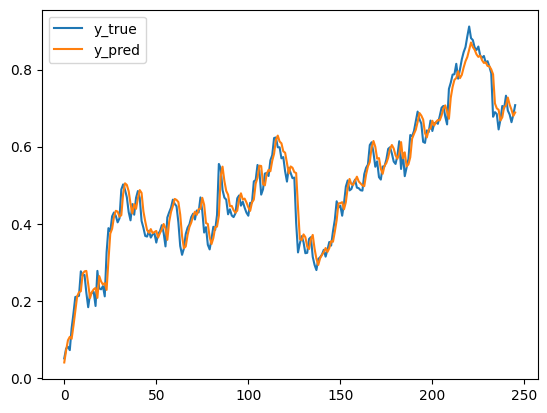

In [ ]:
pd.DataFrame({'y_true': y_test.reshape(-1),
              'y_pred': np.array(y_pred).reshape(-1)}).plot()

**Getting the predictions on the original scale, then compute the RMSE again and plot the forecast results**

In [ ]:
# Using a mask 2D array to perform inverse transformation on the scaled predictions
mask_inv_preds = mm_scaler.inverse_transform(np.concatenate((np.zeros(shape = (x_test.shape[0], x_test.shape[1])), np.array(y_pred)), axis = 1))

test_y_preds_not_scaled = mask_inv_preds[:, -1]
test_y_true_not_scaled = cisco[-len(y_test):]

test_compare = pd.DataFrame({'Date': cisco_df['Date'][-len(y_test):],
                             'True values': test_y_true_not_scaled,
                             'Predictions': test_y_preds_not_scaled})
test_compare['Residual'] = test_compare['Predictions'] - test_compare['True values']
test_compare.loc[len(test_compare)] = ['', '', '', 'Test RMSE = ' + str(round(mean_squared_error(
    y_true = test_y_true_not_scaled, y_pred = test_y_preds_not_scaled, squared = False), 3))]

test_compare

,Date,True values,Predictions,Residual
2270,2022-10-17,41.299999,41.095708,-0.204291
2271,2022-10-18,41.790001,41.697075,-0.092926
2272,2022-10-19,41.880001,42.203594,0.323593
2273,2022-10-20,41.709999,42.374227,0.664228
2274,2022-10-21,42.799999,42.274475,-0.525524
...,...,...,...,...
2512,2023-10-04,53.450001,53.940813,0.490812
2513,2023-10-05,53.07,53.692234,0.622234
2514,2023-10-06,53.450001,53.383088,-0.066913
2515,2023-10-09,53.919998,53.55505,-0.364948


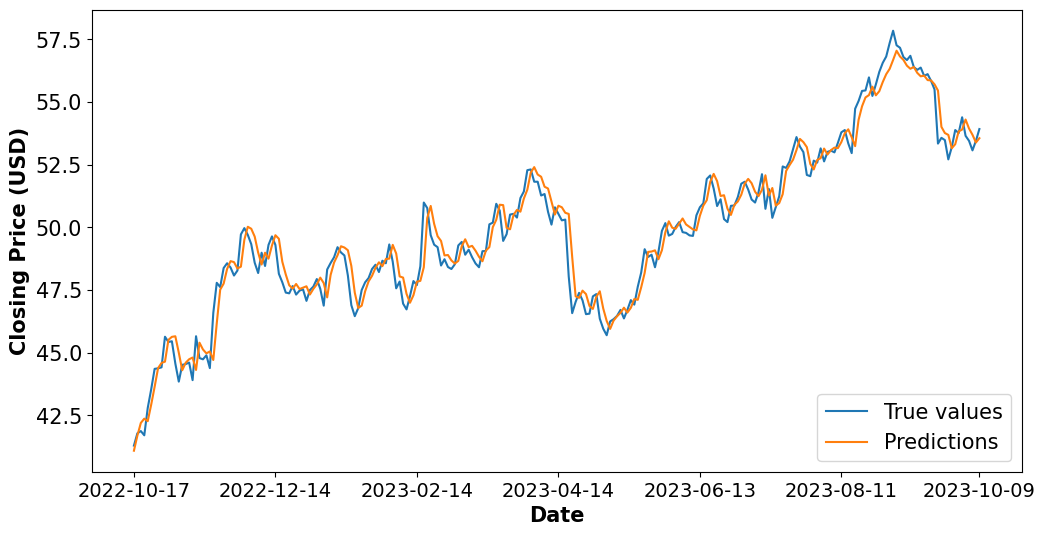

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(cisco_df['Date'][-len(y_test):], test_y_true_not_scaled, label = 'True values')
ax.plot(cisco_df['Date'][-len(y_test):], test_y_preds_not_scaled, label = 'Predictions')
ax.set_xticks([cisco_df['Date'][-len(y_test):].values[i] for i in range(len(y_test)) if i%41 == 0] + [cisco_df['Date'].values[-1]])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 15)
plt.xlabel('Date', fontdict = {'size': 15, 'weight': 'bold'})
plt.ylabel('Closing Price (USD)', fontdict = {'size': 15, 'weight': 'bold'})
plt.legend(loc = "lower right", prop = { "size": 15})
plt.show()


# 6. Examining the forecast residuals on the testing sequence

Based on the plots below, it was observed that the GRU model has satisfied all four criteria of prediction residuals for an effective model, including zero mean, constant variance, a normal distribution, and no autocorrelation.

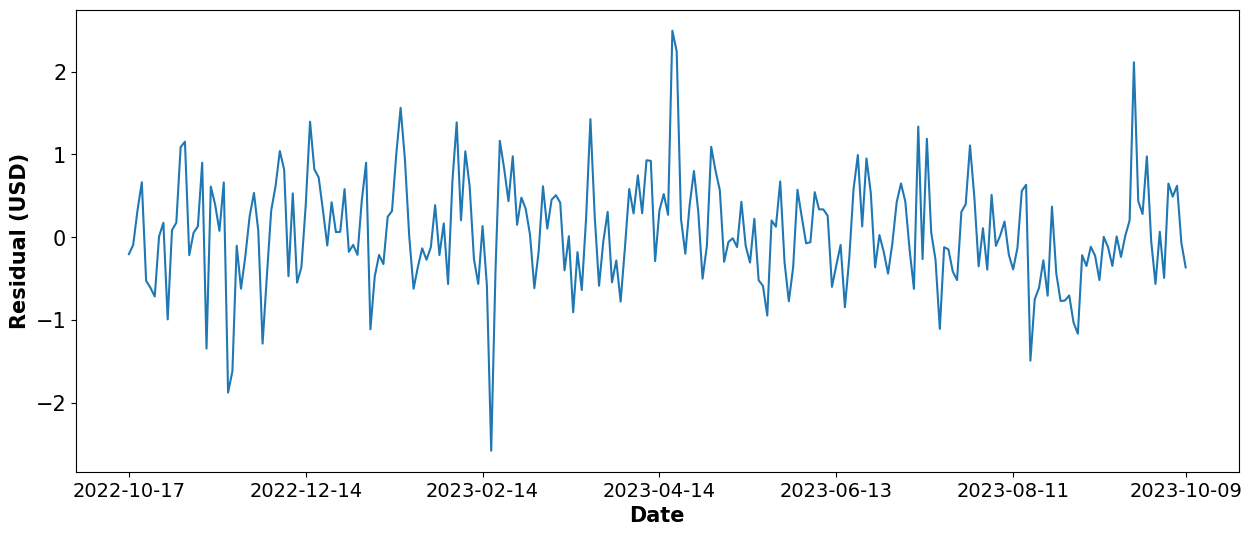

In [49]:
plt.plot(test_compare['Date'], test_compare['Residual'])
plt.xticks([cisco_df['Date'][-len(y_test):].values[i] for i in range(len(y_test)) if i%41 == 0] + [cisco_df['Date'].values[-1]])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 15)
plt.xlabel('Date', fontdict = {'size': 15, 'weight': 'bold'})
plt.ylabel('Residual (USD)', fontdict = {'size': 15, 'weight': 'bold'})
plt.show()


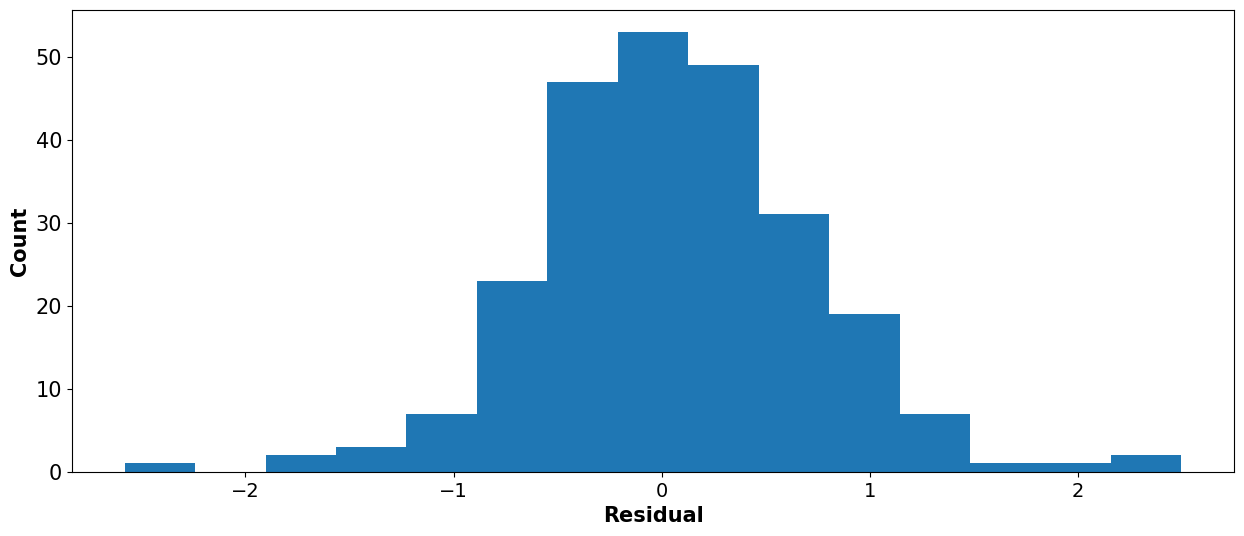

In [52]:
plt.hist(test_compare['Residual'], bins = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 15)
plt.ylabel('Count', fontdict = {'size': 15, 'weight': 'bold'})
plt.xlabel('Residual', fontdict = {'size': 15, 'weight': 'bold'})
plt.show()

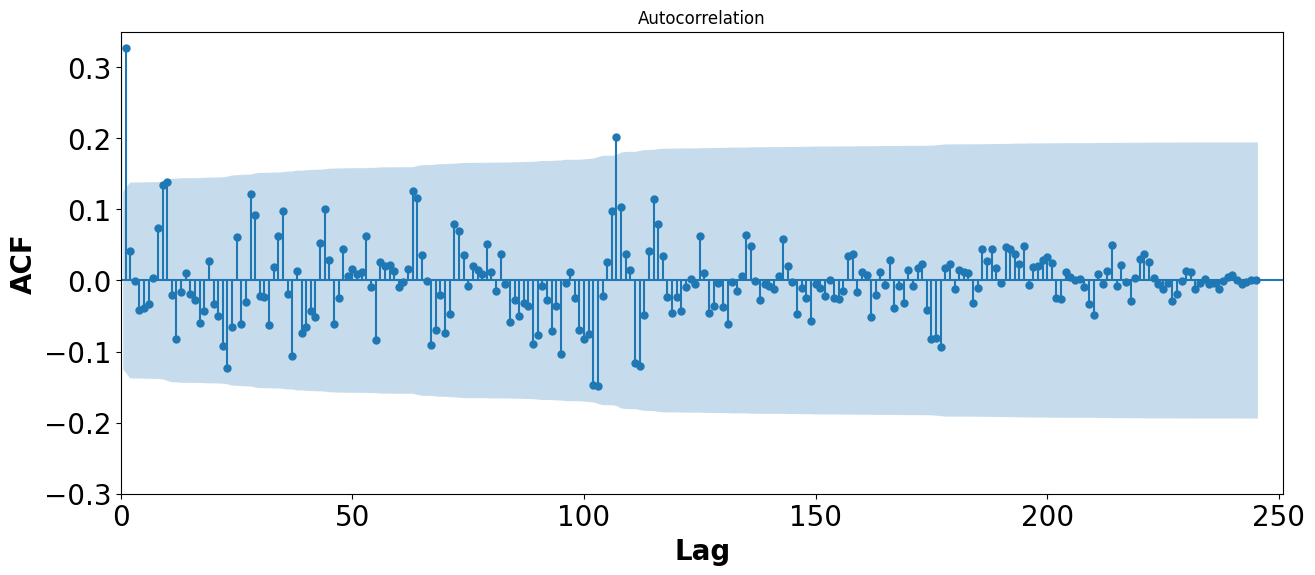

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize = (15, 6))
plot_acf(test_compare['Residual'], lags = 245, alpha = 0.05)
plt.xlim(0, 251) # to omit the first lag
plt.ylim(-0.3, 0.35)
plt.xlabel('Lag', fontdict = {'size': 20, 'weight': 'bold'})
plt.ylabel('ACF', fontdict = {'size': 20, 'weight': 'bold'})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()